In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the dataset
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

11490434/11490434 [==============================] - 2s 0us/step


In [2]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

generator = make_generator_model()
discriminator = make_discriminator_model()


In [3]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [4]:
import os
import time

EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# Seed for generating images
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs):
    gen_losses = []
    disc_losses = []

    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

        gen_losses.append(gen_loss)
        disc_losses.append(disc_loss)

        print(f'Time for epoch {epoch + 1} is {time.time() - start} sec')

    return gen_losses, disc_losses

gen_losses, disc_losses = train(train_dataset, EPOCHS)


Time for epoch 1 is 21.11911964416504 sec
Time for epoch 2 is 9.904676914215088 sec
Time for epoch 3 is 9.959883689880371 sec
Time for epoch 4 is 10.076929330825806 sec
Time for epoch 5 is 10.157193183898926 sec
Time for epoch 6 is 10.27993392944336 sec
Time for epoch 7 is 10.361423969268799 sec
Time for epoch 8 is 10.531439542770386 sec
Time for epoch 9 is 10.607112884521484 sec
Time for epoch 10 is 10.708271503448486 sec
Time for epoch 11 is 10.769335746765137 sec
Time for epoch 12 is 10.688755512237549 sec
Time for epoch 13 is 10.620409965515137 sec
Time for epoch 14 is 10.582803726196289 sec
Time for epoch 15 is 10.567059755325317 sec
Time for epoch 16 is 10.607561826705933 sec
Time for epoch 17 is 10.620457887649536 sec
Time for epoch 18 is 10.629411220550537 sec
Time for epoch 19 is 10.645612478256226 sec
Time for epoch 20 is 10.6394202709198 sec
Time for epoch 21 is 10.662048101425171 sec
Time for epoch 22 is 10.660587549209595 sec
Time for epoch 23 is 10.672553777694702 sec
Tim

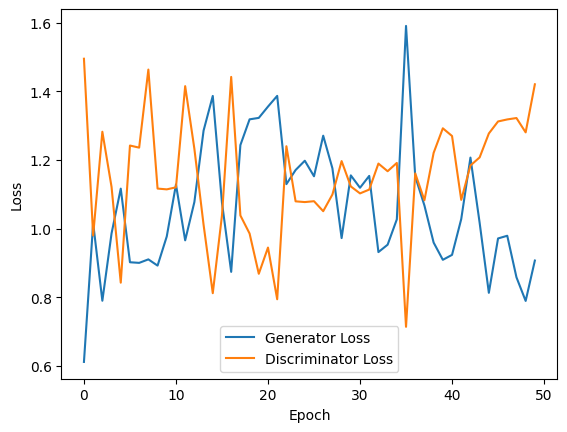

Minimum Generator Loss: 0.6114434599876404
Minimum Discriminator Loss: 0.7137385606765747


In [5]:
plt.plot(gen_losses, label='Generator Loss')
plt.plot(disc_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

min_gen_loss = min(gen_losses)
min_disc_loss = min(disc_losses)

print(f'Minimum Generator Loss: {min_gen_loss}')
print(f'Minimum Discriminator Loss: {min_disc_loss}')


In [6]:
def make_improved_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 512)))
    assert model.output_shape == (None, 7, 7, 512)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 28, 28, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

def make_improved_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

improved_generator = make_improved_generator_model()
improved_discriminator = make_improved_discriminator_model()


In [7]:
improved_generator_optimizer = tf.keras.optimizers.Adam(1e-4)
improved_discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

def improved_train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = improved_generator(noise, training=True)

        real_output = improved_discriminator(images, training=True)
        fake_output = improved_discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, improved_generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, improved_discriminator.trainable_variables)

    improved_generator_optimizer.apply_gradients(zip(gradients_of_generator, improved_generator.trainable_variables))
    improved_discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, improved_discriminator.trainable_variables))

    return gen_loss, disc_loss

def improved_train(dataset, epochs):
    improved_gen_losses = []
    improved_disc_losses = []

    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            gen_loss, disc_loss = improved_train_step(image_batch)

        improved_gen_losses.append(gen_loss)
        improved_disc_losses.append(disc_loss)

        print(f'Time for epoch {epoch + 1} is {time.time() - start} sec')

    return improved_gen_losses, improved_disc_losses

improved_gen_losses, improved_disc_losses = improved_train(train_dataset, EPOCHS)


Time for epoch 1 is 73.126629114151 sec
Time for epoch 2 is 81.90328764915466 sec
Time for epoch 3 is 61.30200791358948 sec
Time for epoch 4 is 59.677411794662476 sec
Time for epoch 5 is 60.019625663757324 sec
Time for epoch 6 is 59.70476055145264 sec
Time for epoch 7 is 59.77570176124573 sec
Time for epoch 8 is 59.77247977256775 sec
Time for epoch 9 is 81.90349745750427 sec
Time for epoch 10 is 60.16478490829468 sec
Time for epoch 11 is 59.64312171936035 sec
Time for epoch 12 is 59.82308077812195 sec
Time for epoch 13 is 60.02626943588257 sec
Time for epoch 14 is 59.878429889678955 sec
Time for epoch 15 is 81.90308046340942 sec
Time for epoch 16 is 81.90405821800232 sec
Time for epoch 17 is 60.132232427597046 sec
Time for epoch 18 is 59.78271746635437 sec
Time for epoch 19 is 59.76346039772034 sec
Time for epoch 20 is 81.90249705314636 sec
Time for epoch 21 is 81.90273356437683 sec
Time for epoch 22 is 60.12492895126343 sec
Time for epoch 23 is 59.9409863948822 sec
Time for epoch 24 i

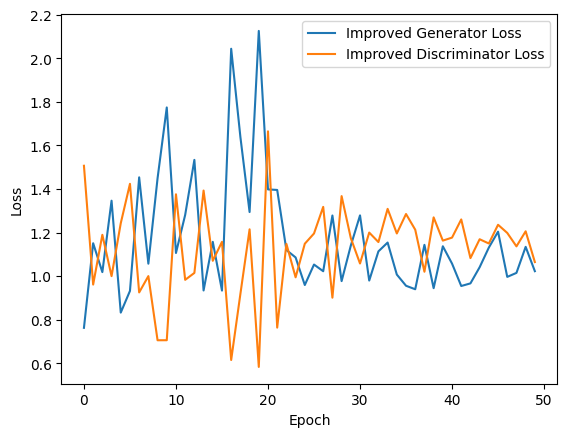

Minimum Improved Generator Loss: 0.7625112533569336
Minimum Improved Discriminator Loss: 0.5830528140068054


In [8]:
plt.plot(improved_gen_losses, label='Improved Generator Loss')
plt.plot(improved_disc_losses, label='Improved Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

min_improved_gen_loss = min(improved_gen_losses)
min_improved_disc_loss = min(improved_disc_losses)

print(f'Minimum Improved Generator Loss: {min_improved_gen_loss}')
print(f'Minimum Improved Discriminator Loss: {min_improved_disc_loss}')


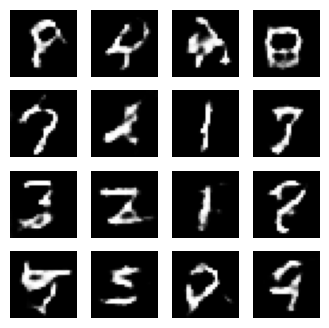

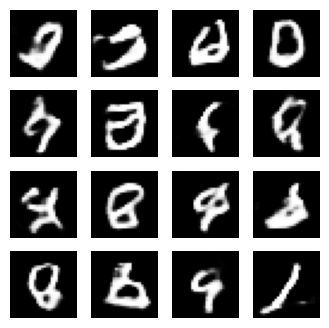

In [9]:
# Generate and save images from the initial model
initial_noise = tf.random.normal([num_examples_to_generate, noise_dim])
initial_generated_images = generator(initial_noise, training=False)

fig = plt.figure(figsize=(4, 4))

for i in range(initial_generated_images.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(initial_generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

plt.savefig('initial_model.png')

# Generate and save images from the improved model
improved_noise = tf.random.normal([num_examples_to_generate, noise_dim])
improved_generated_images = improved_generator(improved_noise, training=False)

fig = plt.figure(figsize=(4, 4))

for i in range(improved_generated_images.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(improved_generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

plt.savefig('improved_model.png')
